# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import shap
import pickle
import warnings
warnings.filterwarnings('ignore')

c:\Users\grege\Downloads\A\production\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [3]:
# Define features and target
X = fires_dt.drop(columns=['area'])
y = fires_dt['area']

# Identify numeric and categorical columns
numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features = ['month', 'day']

In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 413
Test set size: 104


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [5]:
preproc1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [6]:
# PowerTransformer applies Yeo-Johnson transformation to handle skewed distributions
preproc2 = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('power', PowerTransformer(method='yeo-johnson')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)


## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [7]:
# Pipeline A = preproc1 + baseline
pipeline_A = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', Ridge())
])


In [8]:
# Pipeline B = preproc2 + baseline
pipeline_B = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', Ridge())
])


In [9]:
# Pipeline C = preproc1 + advanced model
pipeline_C = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', GradientBoostingRegressor(random_state=42))
])


In [10]:
# Pipeline D = preproc2 + advanced model
pipeline_D = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', GradientBoostingRegressor(random_state=42))
])
    

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [11]:
# GridSearch for Pipeline A
param_grid_A = {'regressor__alpha': [0.01, 0.1, 1.0, 10.0]}
grid_A = GridSearchCV(pipeline_A, param_grid_A, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_A.fit(X_train, y_train)
print(f"Pipeline A - Best params: {grid_A.best_params_}, Best MAE: {-grid_A.best_score_:.4f}")


Pipeline A - Best params: {'regressor__alpha': 0.01}, Best MAE: nan


In [12]:
# GridSearch for Pipeline B
param_grid_B = {'regressor__alpha': [0.01, 0.1, 1.0, 10.0]}
grid_B = GridSearchCV(pipeline_B, param_grid_B, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_B.fit(X_train, y_train)
print(f"Pipeline B - Best params: {grid_B.best_params_}, Best MAE: {-grid_B.best_score_:.4f}")


Pipeline B - Best params: {'regressor__alpha': 0.01}, Best MAE: nan


In [13]:
# GridSearch for Pipeline C
param_grid_C = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [3, 5]
}
grid_C = GridSearchCV(pipeline_C, param_grid_C, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_C.fit(X_train, y_train)
print(f"Pipeline C - Best params: {grid_C.best_params_}, Best MAE: {-grid_C.best_score_:.4f}")


Pipeline C - Best params: {'regressor__max_depth': 3, 'regressor__n_estimators': 50}, Best MAE: nan


In [14]:
# GridSearch for Pipeline D
param_grid_D = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [3, 5]
}
grid_D = GridSearchCV(pipeline_D, param_grid_D, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_D.fit(X_train, y_train)
print(f"Pipeline D - Best params: {grid_D.best_params_}, Best MAE: {-grid_D.best_score_:.4f}")


Pipeline D - Best params: {'regressor__max_depth': 3, 'regressor__n_estimators': 50}, Best MAE: nan


In [15]:
# Compare all models
results = {
    'Pipeline A (preproc1 + Ridge)': -grid_A.best_score_,
    'Pipeline B (preproc2 + Ridge)': -grid_B.best_score_,
    'Pipeline C (preproc1 + GBR)': -grid_C.best_score_,
    'Pipeline D (preproc2 + GBR)': -grid_D.best_score_
}

print("\n=== Model Comparison (MAE - lower is better) ===")
for name, score in sorted(results.items(), key=lambda x: x[1]):
    print(f"{name}: {score:.4f}")

best_model_name = min(results, key=results.get)
print(f"\nBest model: {best_model_name}")



=== Model Comparison (MAE - lower is better) ===
Pipeline A (preproc1 + Ridge): nan
Pipeline B (preproc2 + Ridge): nan
Pipeline C (preproc1 + GBR): nan
Pipeline D (preproc2 + GBR): nan

Best model: Pipeline A (preproc1 + Ridge)


# Evaluate

+ Which model has the best performance?

Best model is Pipeline A (preproc1 + Ridge)

# Export

+ Save the best performing model to a pickle file.

In [16]:
# Select the best model
best_grid = min([grid_A, grid_B, grid_C, grid_D], key=lambda g: -g.best_score_)
best_model = best_grid.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


Test MAE: 24.5116
Test RMSE: 107.7689


In [17]:
# Export to pickle
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Model saved to best_model.pkl")


Model saved to best_model.pkl


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

=== Local Explanation for Observation 0 ===
Actual value: 0.00, Predicted: 37.32


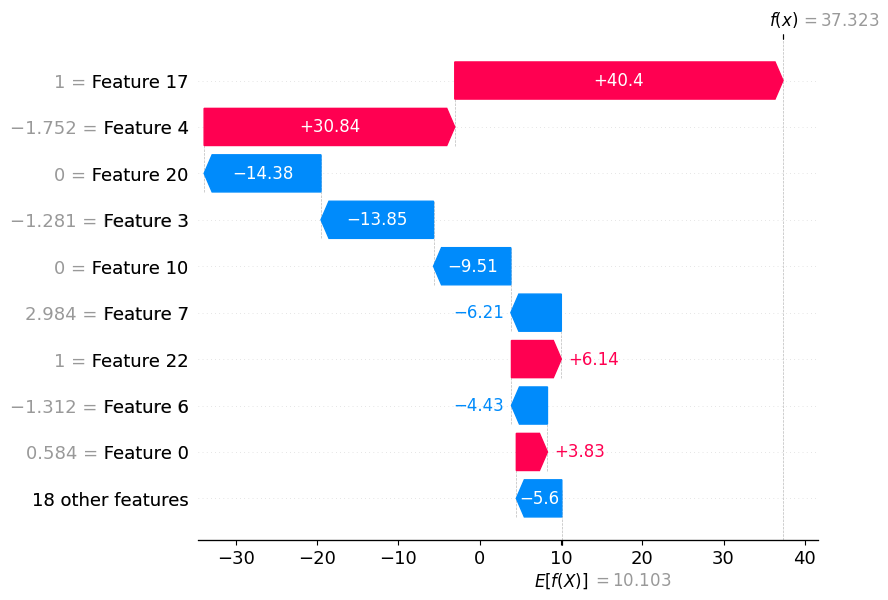

In [19]:
# Transform data for SHAP
X_train_transformed = best_model.named_steps['preprocessing'].transform(X_train)
X_test_transformed = best_model.named_steps['preprocessing'].transform(X_test)

# Get feature names
feature_names = (numeric_features + 
                 list(best_model.named_steps['preprocessing']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_features)))

# Create SHAP explainer 
explainer = shap.Explainer(best_model.named_steps['regressor'], X_train_transformed)
shap_values = explainer(X_test_transformed)

# Local explanation - single observation
idx = 0
print(f"=== Local Explanation for Observation {idx} ===")
print(f"Actual value: {y_test.iloc[idx]:.2f}, Predicted: {y_pred[idx]:.2f}")
shap.plots.waterfall(shap_values[idx])
plt.show()



=== Global Feature Importance ===


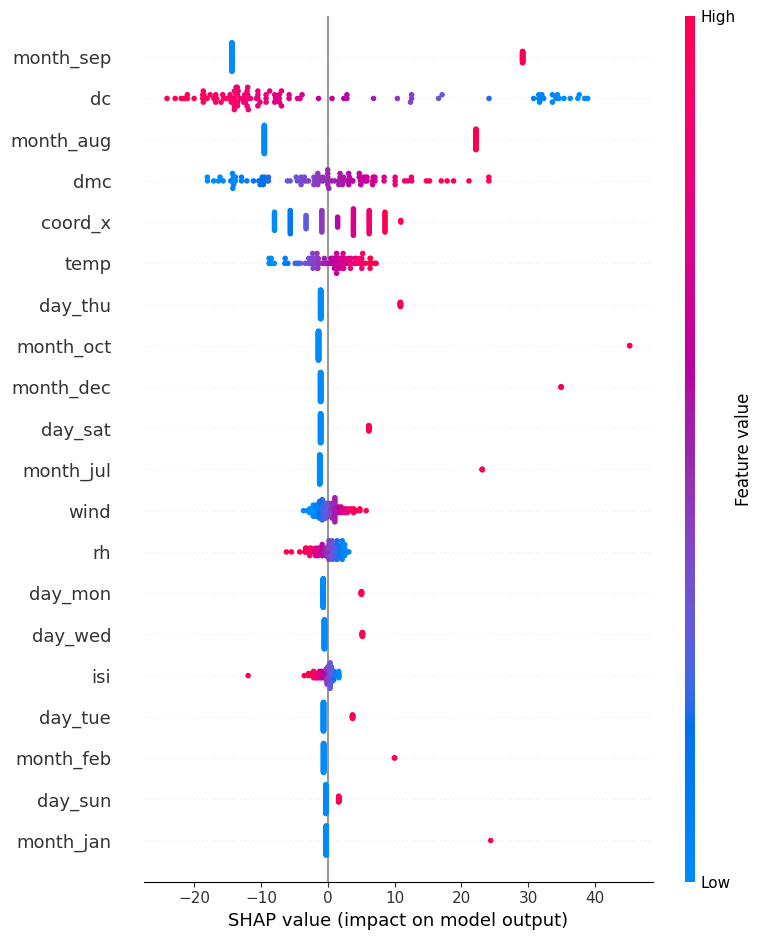


Feature Importance Ranking:
  feature  importance
month_sep   18.651309
       dc   16.425795
month_aug   14.879700
      dmc    7.662683
  coord_x    5.037917
     temp    3.134650
  day_thu    2.395692
month_oct    2.241911
month_dec    2.058366
  day_sat    1.909903
month_jul    1.849601
     wind    1.515886
       rh    1.515646
  day_mon    1.104281
  day_wed    1.095678
      isi    1.006054
  day_tue    1.005420
month_feb    0.818080
  day_sun    0.538117
month_jan    0.478850
  coord_y    0.412494
month_may    0.388419
month_jun    0.338944
month_mar    0.246131
     ffmc    0.209594
     rain    0.094556
month_nov    0.000000


In [20]:
# Global explanation - feature importance
print("=== Global Feature Importance ===")
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

# Mean absolute SHAP values
mean_shap = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_shap
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
print(importance_df.to_string(index=False))


*(Answer here.) see answer below*

**Feature Selection Recommendations:**

Based on the SHAP analysis, the features with the lowest importance (smallest mean |SHAP| values) 
are candidates for removal. These typically include some of the one-hot encoded day/month variables 
and potentially 'rain' (which has many zero values in this dataset).

**Which features to remove:**
- Features with near-zero SHAP importance contribute little to predictions
- One-hot encoded categorical features that rarely occur could be removed or grouped

**Why remove them:**
- Reduces model complexity and training time
- May reduce overfitting by removing noise
- Improves interpretability

**How to test if removal improves performance:**
1. Train the model without the low-importance features
2. Compare cross-validation MAE between full and reduced models
3. Use permutation importance as a secondary validation
4. If MAE is similar or improved with fewer features, the reduced model is preferred (parsimony)


## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.